In [15]:
import kagglehub
import os

# Download the dataset
dataset_path = kagglehub.dataset_download("franciscoescobar/satellite-images-of-water-bodies")

# Check the downloaded files
print("Dataset is stored at:", dataset_path)
print("Files in dataset:", os.listdir(dataset_path))

Dataset is stored at: /Users/srinivasadesikan/.cache/kagglehub/datasets/franciscoescobar/satellite-images-of-water-bodies/versions/2
Files in dataset: ['Water Bodies Dataset']


In [16]:
import os
import numpy as np
from tqdm import tqdm
import cv2 as cv
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras import Model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout


In [17]:
base_path = "/Users/srinivasadesikan/.cache/kagglehub/datasets/franciscoescobar/satellite-images-of-water-bodies/versions/2/Water Bodies Dataset/"
image_path = os.path.join(base_path, "Images/")
mask_path = os.path.join(base_path, "Masks/")


In [18]:
print(os.path.exists(image_path))
print(os.listdir(image_path) if os.path.exists(image_path) else "Path not found")


True
['water_body_8448.jpg', 'water_body_2171.jpg', 'water_body_1478.jpg', 'water_body_1336.jpg', 'water_body_8474.jpg', 'water_body_8312.jpg', 'water_body_1450.jpg', 'water_body_7035.jpg', 'water_body_1444.jpg', 'water_body_8460.jpg', 'water_body_7753.jpg', 'water_body_7960.jpg', 'water_body_7948.jpg', 'water_body_2367.jpg', 'water_body_7579.jpg', 'water_body_1108.jpg', 'water_body_8892.jpg', 'water_body_2415.jpg', 'water_body_8138.jpg', 'water_body_2373.jpg', 'water_body_1652.jpg', 'water_body_7223.jpg', 'water_body_8110.jpg', 'water_body_7545.jpg', 'water_body_8676.jpg', 'water_body_1134.jpg', 'water_body_7551.jpg', 'water_body_8662.jpg', 'water_body_1120.jpg', 'water_body_2429.jpg', 'water_body_1646.jpg', 'water_body_7237.jpg', 'water_body_775.jpg', 'water_body_8851.jpg', 'water_body_8689.jpg', 'water_body_8845.jpg', 'water_body_2398.jpg', 'water_body_1849.jpg', 'water_body_1691.jpg', 'water_body_7586.jpg', 'water_body_7592.jpg', 'water_body_1685.jpg', 'water_body_985.jpg', 'water_

In [19]:
image_names = sorted(next(os.walk(image_path))[-1])
mask_names = sorted(next(os.walk(mask_path))[-1])


In [20]:
SIZE = 128

In [21]:
images = np.zeros(shape=(len(image_names), SIZE, SIZE, 3))
masks = np.zeros(shape=(len(image_names), SIZE, SIZE, 1))


In [22]:
for id in tqdm(range(len(image_names)), desc="Images"):
    path = image_path + image_names[id]
    img = np.asarray(Image.open(path)).astype('float') / 255.  
    img = cv.resize(img, (SIZE, SIZE), cv.INTER_AREA)
    images[id] = img


Images: 100%|██████████| 2841/2841 [00:10<00:00, 263.55it/s] 


In [24]:
for id in tqdm(range(len(mask_names)), desc="Mask"):
    path = mask_path + mask_names[id]
    mask = np.asarray(Image.open(path)).astype('float') / 255.
    mask = cv.resize(mask, (SIZE, SIZE), cv.INTER_AREA)
    masks[id] = mask[:, :, :1]

Mask: 100%|██████████| 2841/2841 [00:09<00:00, 306.51it/s] 


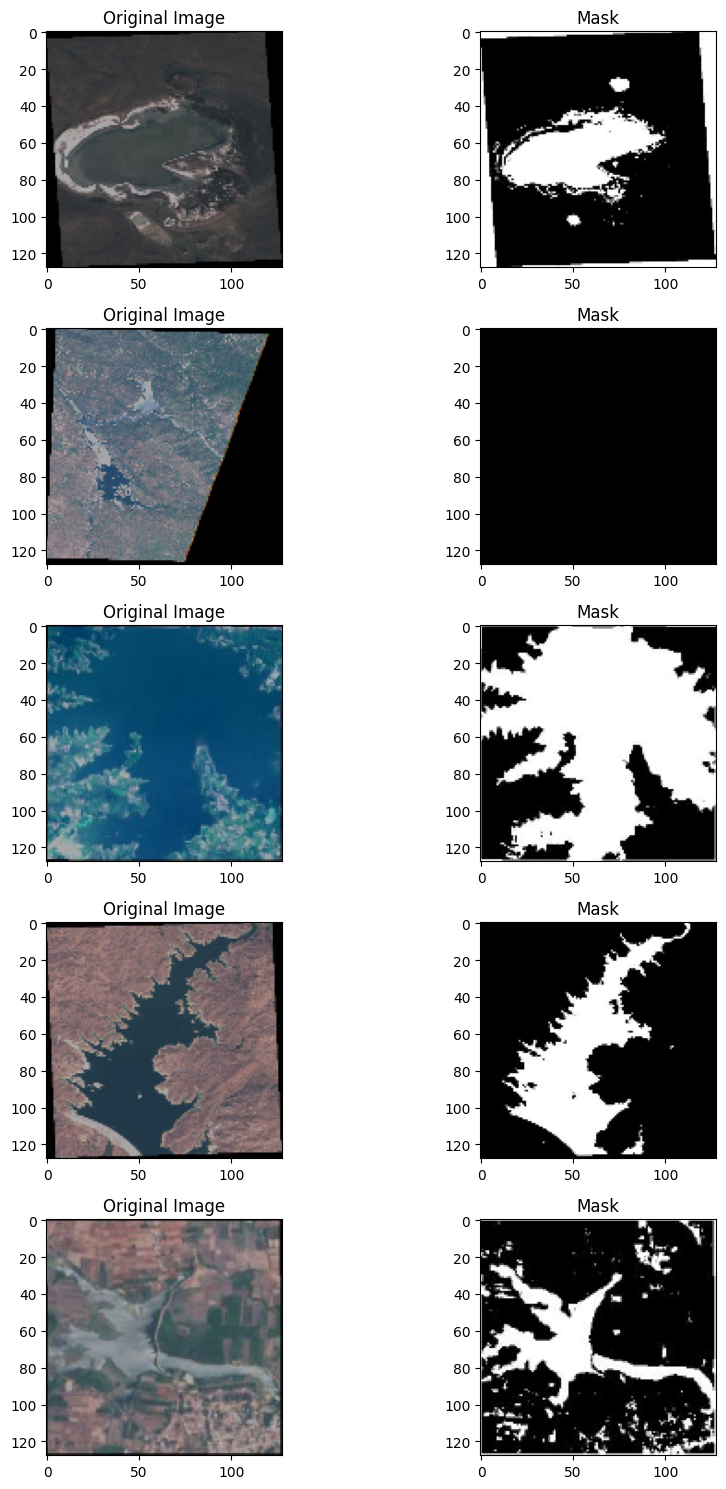

In [25]:
plt.figure(figsize=(10,15))
for i in range(1,11):
  plt.subplot(5,2,i)

  if i%2!=0:
    id = np.random.randint(len(images))
    plt.imshow(images[id], cmap=None)
    plt.title('Original Image')
  elif i%2==0:
    plt.imshow(masks[id].reshape(128,128), cmap='gray')
    plt.title('Mask')

plt.tight_layout()
plt.show()

In [26]:
images_train, images_test, mask_train, mask_test = train_test_split(images, masks, test_size=0.25)

In [36]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, MaxPooling2D, concatenate, BatchNormalization, Activation
from tensorflow.keras.models import Model

def conv_block(inputs, filters):
    x = Conv2D(filters, (3, 3), padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def unet_plus_plus_model(input_shape=(256,256, 3), num_classes=1, deep_supervision=True):
    inputs = Input(shape=input_shape)

    # Encoder
    x_00 = conv_block(inputs, 64)
    x_10 = conv_block(MaxPooling2D()(x_00), 128)
    x_20 = conv_block(MaxPooling2D()(x_10), 256)
    x_30 = conv_block(MaxPooling2D()(x_20), 512)
    x_40 = conv_block(MaxPooling2D()(x_30), 1024)

    # Decoder (Nested)
    x_01 = conv_block(concatenate([x_00, UpSampling2D()(x_10)]), 64)
    x_11 = conv_block(concatenate([x_10, UpSampling2D()(x_20)]), 128)
    x_21 = conv_block(concatenate([x_20, UpSampling2D()(x_30)]), 256)
    x_31 = conv_block(concatenate([x_30, UpSampling2D()(x_40)]), 512)

    x_02 = conv_block(concatenate([x_00, x_01, UpSampling2D()(x_11)]), 64)
    x_12 = conv_block(concatenate([x_10, x_11, UpSampling2D()(x_21)]), 128)
    x_22 = conv_block(concatenate([x_20, x_21, UpSampling2D()(x_31)]), 256)

    x_03 = conv_block(concatenate([x_00, x_01, x_02, UpSampling2D()(x_12)]), 64)
    x_13 = conv_block(concatenate([x_10, x_11, x_12, UpSampling2D()(x_22)]), 128)

    x_04 = conv_block(concatenate([x_00, x_01, x_02, x_03, UpSampling2D()(x_13)]), 64)

    # Output
    if deep_supervision:
        outputs = concatenate([
            Conv2D(num_classes, 1, activation="sigmoid")(x_01),
            Conv2D(num_classes, 1, activation="sigmoid")(x_02),
            Conv2D(num_classes, 1, activation="sigmoid")(x_03),
            Conv2D(num_classes, 1, activation="sigmoid")(x_04)
        ], axis=-1)
    else:
        outputs = Conv2D(num_classes, 1, activation="sigmoid")(x_04)

    model = Model(inputs, outputs, name="UNetPlusPlus")  # Use a valid name
    return model

# Create and summarize the model
model = unet_plus_plus_model(input_shape=(128,128, 3), num_classes=1, deep_supervision=True)
model.summary()


Model: "UNetPlusPlus"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_238 (Conv2D) │ (None, 128, 128,  │      1,792 │ input_layer_7[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_238[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_210      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_239 (Conv2D) │ (None, 128, 128,  │     36,928 │ activation_210[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_239[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_211      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_28    │ (None, 64, 64,    │          0 │ activation_211[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_240 (Conv2D) │ (None, 64, 64,    │     73,856 │ max_pooling2d_28… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_240[0][0]  │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_212      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_241 (Conv2D) │ (None, 64, 64,    │    147,584 │ activation_212[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_241[0][0]  │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_213      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_29    │ (None, 32, 32,    │          0 │ activation_213[0… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_242 (Conv2D) │ (None, 32, 32,    │    295,168 │ max_pooling2d_29… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_242[0][0]

 Total params: 36,644,420 (139.79 MB)

 Trainable params: 36,629,828 (139.73 MB)

 Non-trainable params: 14,592 (57.00 KB)

In [39]:
import tensorflow as tf
from tensorflow.keras.callbacks import Callback

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Define callback to display accuracy
class ShowMetrics(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}: Accuracy = {logs['accuracy']:.4f}, Val Accuracy = {logs['val_accuracy']:.4f}")

# Train the model
epochs = 10
batch_size = 32

history = model.fit(
    images_train, mask_train,
    validation_data=(images_test, mask_test),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[ShowMetrics()]
)


Epoch 1/10


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 128, 128, 1), output.shape=(None, 128, 128, 4)